# **2. Identifying At-Risk Students**
Classifying students who may be at risk of underperforming, enabling targeted interventions to support them.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

c:\Users\FRANK\anaconda3\envs\learn-env\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Load data
df = pd.read_csv("data/student_data.csv")
df.head(3)

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0


In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.columns

Index(['studentid', 'age', 'gender', 'ethnicity', 'parentaleducation',
       'studytimeweekly', 'absences', 'tutoring', 'parentalsupport',
       'extracurricular', 'sports', 'music', 'volunteering', 'gpa',
       'gradeclass'],
      dtype='object')

## Define 'At-Risk' Criteria
Since we're not directly using the `gradeclass` column, we'll decide on what constitutes "at-risk" based on features like:

- Absences: Define a threshold (e.g., >20 absences).
- Parental Support: Low parental support as an indicator.
- Study Time Weekly: Minimal weekly study time (e.g., <5 hours).
- GPA: GPA below a certain threshold (e.g., <2.0).

Then we'll create a binary target variable (at_risk) based on these criteria:

- 1 for at-risk students.
- 0 for students performing adequately.

To simplify this process we'll be working with the most influential features in our previous models for predicting student gradeclass as they're already deemed suitable for determining student grades. We might as well apply the same to identify the students who may be at risk of underperforming.

Let's go ahead and inspect the summary statistics for the features of interest to help us refine thresholds for identifying at-risk students

In [5]:
df = df.drop(columns=['studentid', 'age', 'gender', 'ethnicity', 'parentaleducation',
                'extracurricular', 'sports', 'music', 'volunteering', 'tutoring'])

In [6]:
features = ['absences', 'parentalsupport', 'studytimeweekly', 'gpa']
df[features].describe()

,absences,parentalsupport,studytimeweekly,gpa
count,2392.000000,2392.000000,2392.000000,2392.000000
mean,14.541388,2.122074,9.771992,1.906186
std,8.467417,1.122813,5.652774,0.915156
min,0.000000,0.000000,0.001057,0.000000
25%,7.000000,1.000000,5.043079,1.174803
50%,15.000000,2.000000,9.705363,1.893393
75%,22.000000,3.000000,14.408410,2.622216
max,29.000000,4.000000,19.978094,4.000000


Based on what we have, we can implement the following threshold ideas:
- Students with **absences > 22** (above the 75th percentile) could be considered at risk. This captures students with significantly higher absences compared to the majority.
- Low parental support values (e.g. **<= 1**, which includes the bottom 25th percentile) could indicate at-risk students.
- Students **studying < 5 hours weekly** (below the 25th percentile) could be flagged as at risk.
- A **GPA < 1.17** (below the 25th percentile) could indicate at-risk students. This highlights those whose GPA is well below average.

With this in mind, we will combine the thresholds to define the at-risk label.

In [7]:
#  -----------------------------------------------Approach 1---------------------------------------------------------
# Since our goal for detection is **early detection** and **broad support** in the sense that we wish to capture students struggling in different aspects (e.g. attendance issues, 
# lack of study time, low gpa), we'll go with the **OR(|)** logic which is amore inclusive approach. This should help with early intervention, as even one risk factor can 
# negatively affect performance.

# It's however worth noting that this logic might flag students who are actually doing well in some areas e.g. high GPA but many absenses and could subsequently lead to 
# false positives, increasing unnecessary interventions.
# --------------------------------------------------------------------------------------------------------------------
# # Define thresholds
# absences_threshold = 22  
# parentalsupport_threshold = 1  
# studytime_threshold = 5  
# gpa_threshold = 1.17

# # Create 'at_risk' target
# df['at_risk'] = np.where(
#     (df['absences'] > absences_threshold) |
#     (df['parentalsupport'] <= parentalsupport_threshold) |
#     (df['studytimeweekly'] < studytime_threshold) |
#     (df['gpa'] < gpa_threshold),
#     1,  # At risk
#     0   # Not at risk
# )

In [8]:
# Define thresholds
absences_threshold = 22  
parentalsupport_threshold = 1  
studytime_threshold = 5  
gpa_threshold = 1.17

# Define weights
weights = {
    'absences': 0.35,
    'parentalsupport': 0.20,
    'studytimeweekly': 0.20,
    'gpa': 0.40
}

# Compute risk scores
df['risk_score'] = (
    (df['absences'] > absences_threshold) * weights['absences'] +
    (df['parentalsupport'] <= parentalsupport_threshold) * weights['parentalsupport'] +
    (df['studytimeweekly'] < studytime_threshold) * weights['studytimeweekly'] +
    (df['gpa'] < gpa_threshold) * weights['gpa']
)

# Classify at-risk students based on threshold
df['at_risk_weighted'] = np.where(df['risk_score'] >= 0.5, 1, 0)


at_risk_weighted = df['at_risk_weighted'].value_counts()

print("\nAt-Risk Classification using Weighted Approach:")
print(at_risk_weighted)


At-Risk Classification using Weighted Approach:
0    1818
1     574
Name: at_risk_weighted, dtype: int64


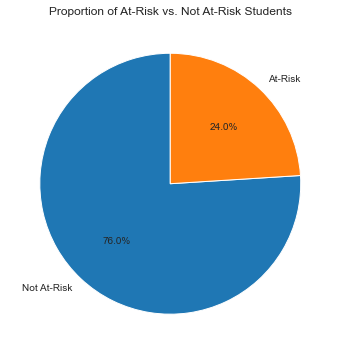

In [9]:
# Count the number of at-risk and not-at-risk students
at_risk_weighted_counts = df['at_risk_weighted'].value_counts()

# Define labels and sizes for the pie chart
labels = ['Not At-Risk', 'At-Risk']
sizes = at_risk_weighted_counts.values

# Define colors for better visualization
colors = ['#1f77b4', '#ff7f0e']  # Blue and orange

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Proportion of At-Risk vs. Not At-Risk Students')
plt.show()

In [10]:
df['gpa'].mean()

1.9061863027265407

In [11]:
### Criteria 2: Weighted Approach ###

# # Define risk factor weights (adjustable)
# weights = {
#     'absences': 1.5,  # High absences have strong impact
#     'parentalsupport': 2.0,  # Lack of support is critical
#     'studytimeweekly': 1.0,  # Low study time contributes
#     'gpa': 2.5  # GPA is the strongest indicator
# }

# # Compute individual risk contributions (binary: 1 if criteria met, 0 otherwise)
# df['risk_absences'] = np.where(df['absences'] > 22, 1, 0) * weights['absences']
# df['risk_parentalsupport'] = np.where(df['parentalsupport'] <= 1, 1, 0) * weights['parentalsupport']
# df['risk_studytime'] = np.where(df['studytimeweekly'] < 5, 1, 0) * weights['studytimeweekly']
# df['risk_gpa'] = np.where(df['gpa'] < 1.17, 1, 0) * weights['gpa']

# # Total risk score
# df['total_risk_score'] = (
#     df['risk_absences'] + df['risk_parentalsupport'] + 
#     df['risk_studytime'] + df['risk_gpa']
# )

# # Define at-risk threshold (e.g., total risk score >= 3.5)
# df['at_risk1'] = np.where(df['total_risk_score'] >= 3.5, 1, 0)

# # Drop temporary columns used for calculations if not needed
# df.drop(columns=['risk_absences', 'risk_parentalsupport', 'risk_studytime', 'risk_gpa'], inplace=True)

In [12]:
df.head(20)

,studytimeweekly,absences,parentalsupport,gpa,gradeclass,risk_score,at_risk_weighted
0,19.833723,7,2,2.929196,2.0,0.00,0
1,15.408756,0,1,3.042915,1.0,0.20,0
2,4.210570,26,2,0.112602,4.0,0.95,1
3,10.028829,14,3,2.054218,3.0,0.00,0
4,4.672495,17,3,1.288061,4.0,0.20,0
5,8.191219,0,1,3.084184,1.0,0.20,0
6,15.601680,10,3,2.748237,2.0,0.00,0
7,15.424496,22,1,1.360143,4.0,0.20,0
8,4.562008,1,2,2.896819,2.0,0.20,0
9,18.444466,0,3,3.573474,0.0,0.00,0


- The **OR condition** is more lenient, marking a larger proportion (60%) of students as at-risk.

    This is because a single risk factor is enough to classify a student as at-risk.

    This approach might however overestimate the number of at-risk students, making it harder to target interventions effectively.

- The **Weighted Approach** is more selective, classifying only 24% (574 students) as at-risk.

    This ensures that students with multiple risk factors are identified, rather than those who have just one mild risk factor.

    This approach might be more realistic because interventions can be prioritized for students facing multiple challenges which is what we choose to work with for this task.

Now that we defined the "At-Risk" label using the weighted approach, let's go ahead and build a machine learning model to predict whether a student is at risk based on their features.

**1. Train-Test Split**

In [13]:
# Define features (X) and target variable (y)
X = df.drop(columns=['at_risk_weighted', 'gradeclass', 'risk_score']) 
y = df['at_risk_weighted'] 

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**2. Data Preprocessing**

Our dataset contains categorical and numerical features that will need processing before feeding it into a model.

- *Categorical Variables*: One-Hot Encoding for nominal features, and keep ordinal features as is.
- *Numerical Variables*: Scaling (StandardScaler) for better model performance.

In [14]:
# # Define categorical and numerical features
# binary_features = ['gender', 'tutoring', 'extracurricular', 'sports', 'music', 'volunteering']
# ordinal_features = ['parentalsupport']
# nominal_features = ['ethnicity', 'parentaleducation']
# numerical_features = ['studytimeweekly', 'absences', 'gpa']

# # Column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('onehot', OneHotEncoder(drop='first'), nominal_features),
#         ('scale', StandardScaler(), numerical_features)
#     ],
#     remainder='passthrough'  # Keep binary and ordinal features as is
# )

In [15]:
# Define selected features for At-Risk classification
ordinal_features = ['parentalsupport']
numerical_features = ['studytimeweekly', 'absences', 'gpa']

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numerical_features),  # Scale numerical features
        ('ordinal', OrdinalEncoder(), ordinal_features) # Encode ordinal features
    ]
)

**3. Model Training and Evaluation.**

To identify the best model, we can train multiple classifiers and evaluate their performance using accuracy, F1-score, and AUC-ROC.

In [16]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100,  max_depth=10, min_samples_split=10, min_samples_leaf=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=5, learning_rate=0.1, n_estimators=100, subsample=0.8, colsample_bytree=0.8, verbosity=0),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True)
}

# Store results
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)  
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for AUC-ROC
    
    # Evaluate performance
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({'Model': name, 'Accuracy': acc, 'F1-Score': f1, 'AUC-ROC': auc})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="AUC-ROC", ascending=False))

                 Model  Accuracy  F1-Score   AUC-ROC
1              XGBoost  0.993737  0.987124  0.999881
0        Random Forest  0.987474  0.973913  0.999713
2  Logistic Regression  0.964509  0.925764  0.993789
3                  SVM  0.962422  0.924370  0.993407


The models still perform exceptionally well on train our data. We can proceed to check for overfitting  by comparing Train and Test test performance

In [17]:
# %pip install pandas==1.5.3

## Overfitting & Underfitting Checks

Now that we have a working pipeline, we need to compare train vs test performance to check for overfitting or underfitting.

**1. Train-Test Performance Check**

In [18]:
# 1. Train-Test Performance Check

# Store results
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Train Performance
    y_train_pred = pipeline.predict(X_train)
    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_proba)
    
    # Test Performance
    y_test_pred = pipeline.predict(X_test)
    y_test_proba = pipeline.predict_proba(X_test)[:, 1]
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    # Append all metrics correctly in one row
    results.append({
        'Model': name,
        'Train Accuracy': train_acc, 'Test Accuracy': test_acc,
        'Train F1': train_f1, 'Test F1': test_f1,
        'Train AUC': train_auc, 'Test AUC': test_auc
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="Test AUC", ascending=False))

                 Model  Train Accuracy  Test Accuracy  Train F1   Test F1  \
1              XGBoost        1.000000       0.993737  1.000000  0.987124   
0        Random Forest        0.998955       0.987474  0.997817  0.973913   
2  Logistic Regression        0.971772       0.964509  0.941304  0.925764   
3                  SVM        0.978045       0.962422  0.954048  0.924370   

   Train AUC  Test AUC  
1   1.000000  0.999881  
0   1.000000  0.999713  
2   0.996579  0.993789  
3   0.997280  0.993407  


In [19]:
results_df

,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Train AUC,Test AUC
0,Random Forest,0.998955,0.987474,0.997817,0.973913,1.000000,0.999713
1,XGBoost,1.000000,0.993737,1.000000,0.987124,1.000000,0.999881
2,Logistic Regression,0.971772,0.964509,0.941304,0.925764,0.996579,0.993789
3,SVM,0.978045,0.962422,0.954048,0.924370,0.997280,0.993407


Random Forest & XGBoost are overfitting, we can try and improve generalization by modifying the parameters for both models

**2. Cross-Validation**

In [20]:
cv_results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Perform cross-validation
    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1').mean()
    cv_auc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc').mean()
    
    cv_results.append({'Model': name, 'CV Accuracy': cv_accuracy, 'CV F1-Score': cv_f1, 'CV AUC-ROC': cv_auc})

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df.sort_values(by="CV AUC-ROC", ascending=False))

                 Model  CV Accuracy  CV F1-Score  CV AUC-ROC
1              XGBoost     0.994774     0.989034    0.999858
0        Random Forest     0.990588     0.980146    0.999513
3                  SVM     0.977522     0.952994    0.996797
2  Logistic Regression     0.971769     0.941165    0.996399


In [21]:
# Store CV results
cv_results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Perform Cross-Validation
    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    cv_auc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')

    # Get predicted probabilities for AUC calculation
    y_cv_pred = cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict')
    y_cv_proba = cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    
    # Calculate performance metrics
    avg_cv_accuracy = cv_accuracy.mean()
    avg_cv_f1 = cv_f1.mean()
    avg_cv_auc = cv_auc.mean()
    
    # Append results
    cv_results.append({
        'Model': name,
        'CV Accuracy': avg_cv_accuracy,
        'CV F1-Score': avg_cv_f1,
        'CV AUC-ROC': avg_cv_auc
    })

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df.sort_values(by="CV AUC-ROC", ascending=False))

                 Model  CV Accuracy  CV F1-Score  CV AUC-ROC
1              XGBoost     0.994774     0.989034    0.999858
0        Random Forest     0.990588     0.980146    0.999513
3                  SVM     0.977522     0.952994    0.996797
2  Logistic Regression     0.971769     0.941165    0.996399


Cross-validation (CV) results are still quite high, indicating strong performance across different data splits. However, XGBoost and Random Forest are still showing near-perfect AUC-ROC scores (~0.999), which strongly suggests overfitting.

SVM and Logistic Regression show more reasonable generalization from the results

**Random Forest Hyperparameter Tuning**

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# rf_param_grid = {
#     'n_estimators': [100, 200, 300], 
#     'max_depth': [5, 10, 15, None],  
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4],  
#     'max_features': ['sqrt', 'log2']
# }

# # Initialize the model
# rf_model = RandomForestClassifier(random_state=42)

# # Grid search with 5-fold CV
# rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
# rf_grid_search.fit(X_train, y_train)

# # Best parameters & score
# print("Best RF Parameters:", rf_grid_search.best_params_)
# print("Best RF AUC-ROC:", rf_grid_search.best_score_)

# -----------------------------7 MINUTES RUNTIME--------------------------------

In [23]:
# Train Random Forest with best parameters
best_rf = RandomForestClassifier(
    max_depth=10, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=300, 
    random_state=42
)

best_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluate performance
rf_test_acc = accuracy_score(y_test, y_pred_rf)
rf_test_f1 = f1_score(y_test, y_pred_rf)
rf_test_auc = roc_auc_score(y_test, y_pred_proba_rf)

# Print test results
print("Final Random Forest Performance on Test Set:")
print(f"Accuracy: {rf_test_acc:.4f}")
print(f"F1-Score: {rf_test_f1:.4f}")
print(f"AUC-ROC: {rf_test_auc:.4f}")

Final Random Forest Performance on Test Set:
Accuracy: 0.9937
F1-Score: 0.9871
AUC-ROC: 1.0000


**Tuning XGBoost Model with GridSearch**

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 300], 
    'max_depth': [3, 5, 7, 10],  
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'lambda': [0, 0.1, 1, 10]  # L2 Regularization
}

# Initialize the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Randomized search with 5-fold CV
xgb_random_search = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=20, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=42)
xgb_random_search.fit(X_train, y_train)

# Best parameters & score
print("Best XGB Parameters:", xgb_random_search.best_params_)
print("Best XGB AUC-ROC:", xgb_random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\FRANK\anaconda3\envs\learn-env\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Best XGB Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'lambda': 0, 'colsample_bytree': 1.0}
Best XGB AUC-ROC: 0.9998804721350666


In [25]:
# Train XGBoost with best parameters
best_xgb = XGBClassifier(
    max_depth=3,
    learning_rate=0.2,
    n_estimators=100,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_lambda=0,  # 'lambda' in XGBoost API
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

best_xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate performance
xgb_test_acc = accuracy_score(y_test, y_pred_xgb)
xgb_test_f1 = f1_score(y_test, y_pred_xgb)
xgb_test_auc = roc_auc_score(y_test, y_pred_proba_xgb)

# Print test results
print("Final XGBoost Performance on Test Set:")
print(f"Accuracy: {xgb_test_acc:.4f}")
print(f"F1-Score: {xgb_test_f1:.4f}")
print(f"AUC-ROC: {xgb_test_auc:.4f}")

Final XGBoost Performance on Test Set:
Accuracy: 0.9937
F1-Score: 0.9871
AUC-ROC: 0.9998


c:\Users\FRANK\anaconda3\envs\learn-env\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\Users\FRANK\anaconda3\envs\learn-env\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


- Both models have identical Accuracy (0/9937) and F1-Score (0.9871).
- Random Forest AUC-ROC = 1.0 on Test Set; suggesting possible overfitting because perfect AUC-ROC on test data is extremely rare.
- XGBoost has slightly lower test AUC-ROC (0.9998) but generalizes slightly better with minimal train-test gap
- Random Forest might be slighly prone to memorizing the data, making XGBoost a safer bet for real-world deployment, in addition to being faster overall and efficient for larger datasets.

## Saving & Model Deployment
**Save Model**

In [26]:
import joblib

# Save the trained XGBoost model
joblib.dump(best_xgb, "xgboost_student_risk_model.pkl")

print("Model saved successfully!")

Model saved successfully!


**Model Testing**

In [27]:
# Load the saved model
loaded_model = joblib.load("xgboost_student_risk_model.pkl")

# Make predictions on the test set
y_pred = loaded_model.predict(X_test)

# Check accuracy
from sklearn.metrics import accuracy_score
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred))

Loaded Model Accuracy: 0.9937369519832986


c:\Users\FRANK\anaconda3\envs\learn-env\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


The accuracy matches earlier results, we're good to go

**Deployment**

In [28]:
with open("xgboost_student_risk_model.pkl", "rb") as file:
    content = file.read()
print(content[:100])  # Print first 100 bytes

b'\x80\x04\x95\x0e\x03\x00\x00\x00\x00\x00\x00\x8c\x0fxgboost.sklearn\x94\x8c\rXGBClassifier\x94\x93\x94)\x81\x94}\x94(\x8c\x0cn_estimators\x94Kd\x8c\tobjective\x94\x8c\x0fbinary:logistic\x94'
